# Advanced Raster Data Processing

The study area of the assignment is the [Delta de Saloum](https://rsis.ramsar.org/ris/288), a Ramsar protect wetland at the coast of Senegal. We will use multi-temporal satellite imagery to monitor the changing water levels of the wetland over time.

In this assignment we will practice working with raster data in Python using _rasterio_ and _numpy_. We will use the _sat-search_ package to search for suitable satellite imagery from the [Amazon AWS Open Data Registry](https://registry.opendata.aws/) . The os package is usually needed and pyproj for reprojecting coordinates. 

In [2]:
import os
import numpy as np
import rasterio as rio
import pyproj
from satsearch import Search
import matplotlib.pyplot as plt

Please refer to the following sources for information on the usage of the packages (or google it): 
* [Rasterio Python Quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html)
* [sat-search Quickstart](https://github.com/sat-utils/sat-search)
* [sat-search Python Tutorial](https://github.com/sat-utils/sat-search/blob/master/tutorial-1.ipynb)

This analysis will include the following steps:
    1. Search suitable satillite imagery
    2. Download satellite imagery
    3. Preprocess satellite imagery
    4. Calculate Water Index
    5. Calculate water frequency

## Step 1: Searching for satellite imagery 

In the first step, we will use the package [sat-search](https://github.com/sat-utils/sat-search) to search for suitable satellite scenes within our study area and [rasterio](https://rasterio.readthedocs.io/en/latest/quickstart.html) to load the data into Python. The search is based on the Spatio-Temporal Asset Catalogs (STAC) format which should make it easier to search and query satellite imagery.  

__FYI:__ [sat-search](https://github.com/sat-utils/sat-search) is developed by [Development Seed](https://developmentseed.org/). Check out their [sat-utils on GitHub](https://github.com/sat-utils).

#### Installation of sat-search:

Before you start you need to install the `sat-search` Python package using `conda install sat-search`.

Let's perform a search for satellite scenes for the area of Heidelberg. You can get metadata about all scenes using the `items()` method.

#### Define search parameters

Let's define some input parameters for our search. The bounding box is already setup correctily using geographic coordinates.

In [3]:
bbox = [-16.811, 13.627, -16.356, 14.14] # [minx, miny, maxx, maxy]

Now we need to specify which scenes are suitable:
* We are interested in all scenes within the year **2019**. 
* **Only Landsat 8 scenes**, since these are easily downloadable via Amazon AWS. 
* **Maximum cloud coverage of 2%** so we get mostly cloud free scenes. 

All parameters of the query are stored in a dictionary. 

In [4]:
time_period = '2014-01-01/2019-01-01'

In [5]:
query = {
    "eo:cloud_cover": {
        "lt": 5
    },
    "collection": {
        "eq": "landsat-8-l1"
    },
    #"time": time_period
}

In [6]:
qq = {
  "bbox": bbox,
  "time": "2018-02-12T00:00:00Z/2018-03-18T12:31:12Z",
  "query": {
    "eo:cloud_cover": {
      "lt": 10
    }
  },
  "sort": [
    {
      "field": "eo:cloud_cover",
      "direction": "desc"
    }
  ]
}

#### Execute the search!

In [7]:
search_result = Search.search(collection='landsat-8-l1', property=["eo:cloud_cover<5"], bbox=bbox, time=time_period)

In [8]:
search_result.found()

0

In [9]:
items = search_result.items()

In [10]:
search_result = Search(bbox=bbox, query=query, time=time_period)

In [19]:
search = Search(bbox=bbox)
print('%s items' % search.found())

items = search.items()
print('%s items' % len(items))
print('%s collections' % len(items._collections))
print(items._collections)

for item in items:
    print(item)

362 items
362 items
6 collections
[landsat-8-l1, cbers4-pan5m, sentinel-2-l1c, cbers4-pan10m, cbers4-mux, cbers4-awfi]
S2B_28PBA_20200805_0
S2B_28PCA_20200805_0
S2A_28PBA_20200731_0
S2A_28PCA_20200731_0
S2B_28PBA_20200726_0
S2B_28PCA_20200726_0
S2A_28PBA_20200721_0
S2A_28PCA_20200721_0
S2B_28PBA_20200716_0
S2B_28PCA_20200716_0
LC82050512020198
LC82050502020198
S2A_28PBA_20200711_0
S2A_28PCA_20200711_0
S2B_28PBA_20200706_0
S2B_28PCA_20200706_0
S2A_28PBA_20200701_0
S2A_28PCA_20200701_0
LC82050512020182
LC82050502020182
S2B_28PBA_20200626_0
S2B_28PCA_20200626_0
S2A_28PBA_20200621_0
S2A_28PCA_20200621_0
S2B_28PBA_20200616_0
S2B_28PCA_20200616_0
LC82050512020166
LC82050502020166
S2A_28PBA_20200611_0
S2A_28PCA_20200611_0
S2B_28PBA_20200606_0
S2B_28PCA_20200606_0
S2A_28PBA_20200601_0
S2A_28PCA_20200601_0
LC82050512020150
LC82050502020150
S2B_28PBA_20200527_0
S2B_28PCA_20200527_0
S2A_28PBA_20200522_0
S2A_28PCA_20200522_0
S2B_28PBA_20200517_0
S2B_28PCA_20200517_0
LC82050512020134
LC820505020201

In [24]:
print(search.items().calendar())

                              2016                              

      October               November              December      
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
                1  2      1  2  3  4  5  6            1  2  3  4  
 3  4  5  6  7  8  9   7  8  9 10 11 12 13   5  6  7  8  9 10 11  
10 11 12 13 14 15 16  14 15 16 17 18 19 20  12 13 14 15 16 17 18  
17 18 19 20 21 22 23  21 22 23 24 25 26 27  19 20 21 22 23 24 25  
24 25 26 27 28 29 30  28 29 30              26 27 28 29 30 31     
31                                                                

                              2017                              

      January               February               March        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
                   1         1  2  3  4  5         1  2  3  4  5  
 2  3  4  5  6  7  8   6  7  8  9 10 11 12   6  7  8  9 10 11 12  
 9 10 11 12 13 14 15  13 14 15 16 17 18 19  13 14 15 16 17 18 19  
16 1

In [60]:
search = Search(query={'eo:cloud_cover': {'lt': 10}})
print('cloud_cover search: %s items' % search.found())

cloud_cover search: 1657458 items


#### So what did we find? 

The object `search_result` is of type `satsearch.search.Search` and has a method `.items()`. Execute it to get the metadata to all scenes found during the search. 

__Tipp:__ When you are working with unfamiliar classes, use frequently use the `type()` and `dir()` functions to learn about how the class works and what it can do.

In [25]:
items = search_result.items()

Explore the scenes object for a bit to find out which attributes and methods it contains. Place your curser next to the dot after the object name and press  `TAB` to get a list of available methods and attributes (see below). If you want to see the doc string of a method, place your cursor on the method name and press `SHIFT` + `TAB`. 

<img src="./img/search_methods.png" width="300">
<img src="./img/docstring.png" width="500">




In [45]:
print(items.summary())

Items (16):
date                      id                        
2020-05-29                LC82050502020150          
2020-05-13                LC82050502020134          
2020-04-27                LC82050512020118          
2020-04-27                LC82050502020118          
2020-04-11                LC82050502020102          
2020-03-26                LC82050512020086          
2020-03-26                LC82050502020086          
2020-03-10                LC82050502020070          
2020-02-07                LC82050512020038          
2020-02-07                LC82050502020038          
2020-01-06                LC82050512020006          
2020-01-06                LC82050502020006          
2019-04-25                LC82050512019115          
2019-04-25                LC82050502019115          
2019-04-09                LC82050512019099          
2019-04-09                LC82050502019099          



__E:__ Answer the following questions using methods from the `scenes` object:
* How many scenes were found?
* On which dates were the scenes captured? (hint: "print the calendar")

In [21]:
items.dates()

[]

In [14]:
print(items.calendar())

                              2019                              

       April                  May                   June        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7         1  2  3  4  5                  1  2  
 8  9 10 11 12 13 14   6  7  8  9 10 11 12   3  4  5  6  7  8  9  
15 16 17 18 19 20 21  13 14 15 16 17 18 19  10 11 12 13 14 15 16  
22 23 24 25 26 27 28  20 21 22 23 24 25 26  17 18 19 20 21 22 23  
29 30                 27 28 29 30 31        24 25 26 27 28 29 30  

        July                 August              September      
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7            1  2  3  4                     1  
 8  9 10 11 12 13 14   5  6  7  8  9 10 11   2  3  4  5  6  7  8  
15 16 17 18 19 20 21  12 13 14 15 16 17 18   9 10 11 12 13 14 15  
22 23 24 25 26 27 28  19 20 21 22 23 24 25  16 17 18 19 20 21 22  
29 30 31              26 27 28 29 30 31     23 24 25 26 27 28 29  

  

In [16]:
n_items = len(items)# your code here
print("{} scenes were found.".format(n_items))

13 scenes were found.


Since is some kind of collection let's iterate over it to find out more details about the individual `scenes`.

In [19]:
type(items)

satstac.itemcollection.ItemCollection

In [186]:
for item in items:
    print(item.properties["eo:row"])

051
050
050
050
050
051
050
051
050
051
050
051
050


__E:__ Explore one of the items in more detail. 

* Using the `.properties` attribute, what is the cloud cover of the Landsat scene?
* Using the `.properties` attribute, what is the coordinate reference system of the scene?
* How many bands does the item (scene) have?
* Which band numbers are the near-infrared (nir) and the short wave infrared band (swir22)?
* Print the assets of the item. What does asset mean in this case? 

We will implement the whole processing chain using one of the scenes as an example. When the processing chain is up and running we will apply it to all Landsat scenes. 

In [172]:
test_item = items[0]

`.properties` attribute shows the metadata of the scene.

In [102]:
item1.properties

{'collection': 'landsat-8-l1',
 'eo:gsd': 15,
 'eo:platform': 'landsat-8',
 'eo:instrument': 'OLI_TIRS',
 'eo:off_nadir': 0,
 'eo:bands': [{'name': 'B1',
   'common_name': 'coastal',
   'gsd': 30,
   'center_wavelength': 0.44,
   'full_width_half_max': 0.02},
  {'name': 'B2',
   'common_name': 'blue',
   'gsd': 30,
   'center_wavelength': 0.48,
   'full_width_half_max': 0.06},
  {'name': 'B3',
   'common_name': 'green',
   'gsd': 30,
   'center_wavelength': 0.56,
   'full_width_half_max': 0.06},
  {'name': 'B4',
   'common_name': 'red',
   'gsd': 30,
   'center_wavelength': 0.65,
   'full_width_half_max': 0.04},
  {'name': 'B5',
   'common_name': 'nir',
   'gsd': 30,
   'center_wavelength': 0.86,
   'full_width_half_max': 0.03},
  {'name': 'B6',
   'common_name': 'swir16',
   'gsd': 30,
   'center_wavelength': 1.6,
   'full_width_half_max': 0.08},
  {'name': 'B7',
   'common_name': 'swir22',
   'gsd': 30,
   'center_wavelength': 2.2,
   'full_width_half_max': 0.2},
  {'name': 'B8',
   

Using `.assets` you can explore the availabel bands of the scene

In [534]:
#item1.assets

## 2. Downloading the satellite data

First, let's create a folder to store the data. 

In [24]:
scene_dir = "./scenes"

The `os` package can help us with interactiong wiht the file system. For example, it can check whether the folder exisits. If not it will create it. 

In [25]:
import os

In [26]:
if not os.path.exists(scene_dir):
    os.mkdir(scene_dir)

### Option 1: Download using sat-search

Using sat-search you can download the data. For example, let's download all metadata files. The os package can take care of the correct file path.

In [125]:
filenames = items.download('MTL', path=os.path.join(scene_dir, "${date}"))

Your `scene_dir` should contain several folders for each Landsat scene containing the MTL file. 

__E:__ Download the band "B1" of the first item.

In [130]:
item1.download("B1", path=os.path.join(scene_dir, "${date}"))

'./scenes/2019-12-21/LC82050512019355_B1.TIF'

### Option 2: Download using rasterio

In the last notebook we learned that rasterio can download images as well. The advantage using rasterio is that we can even specify which spatial extent of the image we want to download using a `window`. This can be very useful when you want to test your method in a small test region with many images, so you don't have to download all the data.

#### 1. Image URL
Each spectral band has a unique URL through which we can download it. This information is stored in the `item.assets`. Since these are stored as a dictionary, so we can access this information using the right keys.

In [27]:
band5_url = item.assets["B3"]["href"]
band5_url

'https://landsat-pds.s3.amazonaws.com/c1/L8/205/050/LC08_L1TP_205050_20190409_20190422_01_T1/LC08_L1TP_205050_20190409_20190422_01_T1_B3.TIF'

#### 2. Convert bounding box in image coordinates

in the last notebook you've learned that the window has to be defined using image coordinates. However, our bounding box is in geogrpahic coordisntes. When we continue using rasterio we will probably need to do this kind of conversion regularly. So it would be worth writing a function for it. :) 

__E:__ Write a function which takes a bounding box with geographic coordinates as a list (same as `bbox`) and the path to the image which we would like to read. The function should return a list containing the the upper left image coordinates and the number of rows and columns. 

__hint:__ The bounding box is given in geographic coordinates. The Landsat scene has a UTM projection. And the window needs image coordinates. So you need to go from geographic coordinates to UTM to image coordinates. `pyproj.transform` can convert point coordinates from one crs to another. In order to convert from crs to image use the functions from the last notebook. 


In [28]:
def geogr_2_image(affine,x, y):
    return ~affine * (x, y)

In [29]:
def image_2_geogr(affine,x, y):
    return affine * (x, y)

In [30]:
import math

In [86]:
def get_window_for_scene(band, bbox):
    
    with rio.open(band) as src:
        affine = src.transform
        crs = src.crs
        
    ul_x, ul_y = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init=str(crs)), bbox[0], bbox[3])
    lr_x, lr_y = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init=str(crs)), bbox[2], bbox[1])
    
    ul_row, ul_col = geogr_2_image(affine, ul_x, ul_y)
    lr_row, lr_col = geogr_2_image(affine, lr_x, lr_y)
    
    ul_row = math.floor(ul_row)
    ul_col = math.floor(ul_col)
    lr_row = math.floor(lr_row)
    lr_col = math.floor(lr_col)
    rows = math.floor(lr_row - ul_row)
    cols = math.floor(lr_col - ul_col)
    
    return rio.windows.Window(ul_row, ul_col, rows, cols)

#### Download the data using rasterio

In [103]:
with rio.open(band5_url) as src:
    band = src.read(1, window=win)
    profile = src.profile

In [105]:
item.properties

{'collection': 'landsat-8-l1',
 'eo:gsd': 15,
 'eo:platform': 'landsat-8',
 'eo:instrument': 'OLI_TIRS',
 'eo:off_nadir': 0,
 'eo:bands': [{'name': 'B1',
   'common_name': 'coastal',
   'gsd': 30,
   'center_wavelength': 0.44,
   'full_width_half_max': 0.02},
  {'name': 'B2',
   'common_name': 'blue',
   'gsd': 30,
   'center_wavelength': 0.48,
   'full_width_half_max': 0.06},
  {'name': 'B3',
   'common_name': 'green',
   'gsd': 30,
   'center_wavelength': 0.56,
   'full_width_half_max': 0.06},
  {'name': 'B4',
   'common_name': 'red',
   'gsd': 30,
   'center_wavelength': 0.65,
   'full_width_half_max': 0.04},
  {'name': 'B5',
   'common_name': 'nir',
   'gsd': 30,
   'center_wavelength': 0.86,
   'full_width_half_max': 0.03},
  {'name': 'B6',
   'common_name': 'swir16',
   'gsd': 30,
   'center_wavelength': 1.6,
   'full_width_half_max': 0.08},
  {'name': 'B7',
   'common_name': 'swir22',
   'gsd': 30,
   'center_wavelength': 2.2,
   'full_width_half_max': 0.2},
  {'name': 'B8',
   

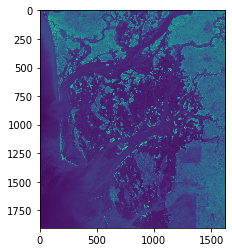

In [104]:
plt.imshow(band)

#### Save image to file

In [97]:
outfile = os.path.join(scene_dir, str(item.date), os.path.basename(band5_url))
with rio.open(outfile, "w", **profile) as dst:
    dst.write(band, 1)

#### 4. Download the green and swir2 band for each scene and save them in the `scene_dir`.

In [101]:
for item in items:
    
    print(item)
    band3_url = item.assets["B3"]["href"]
    band7_url = item.assets["B7"]["href"]

    win = get_window_for_scene(band3_url, bbox)
    
    # band 5 
    with rio.open(band3_url) as src:
        band5 = src.read(1, window=win)
        profile = src.profile
        
    outfile = os.path.join(scene_dir, str(item.date), os.path.basename(band3_url))
    with rio.open(outfile, "w", **profile) as dst:
        dst.write(band, 1)
        
    # band 7 
    with rio.open(band7_url) as src:
        band7 = src.read(1, window=win)
        profile = src.profile
        
    outfile = os.path.join(scene_dir, str(item.date), os.path.basename(band7_url))
    with rio.open(outfile, "w", **profile) as dst:
        dst.write(band, 1)

## 3. Conversion of raw image to reflectance


The spectral bands are still in raw format. Their unit is DN (digital number). But what we need to calculate the NDWI is reflectence values, i.e.  the amount of radiation which has been reflected by the surface at the wavelength of the repective band. Therefore, we need to perform the conversion from DN to reflectance. 

The conversion is performed using a linear function: (see [USGS Documentation](https://www.usgs.gov/land-resources/nli/landsat/using-usgs-landsat-level-1-data-product)
)

$L_{\lambda} = M_L Q_{cal} + A_L$

$L_\lambda$ = TOA spectral radiance (Watts/( m2 * srad * μm))

$M_L$ = Band-specific multiplicative rescaling factor from the metadata (RADIANCE_MULT_BAND_x, where x is the band number)

$A_L$ = Band-specific additive rescaling factor from the metadata (RADIANCE_ADD_BAND_x, where x is the band number)

$Q_{cal}$ =  Quantized and calibrated standard product pixel values (DN)     





To perform this conversion we need to: 
1. Download the metadata files
2. Parse the metadata files in Python and extract the reuqired parameters.
3. Perform the conversion of the spectral bands. 

### 1. Downloading the metadata files

We've actually already done this above using

In [110]:
meta_files = items.download('MTL', path=os.path.join(scene_dir, "${date}"))

### 2. Reading the metadata files in Python
Let's try reading one of the metadata files using the standard `readlines()` method.

In [146]:
with open(meta_files[0]) as src:
    metadata = src.readlines()

In [147]:
metadata

['GROUP = L1_METADATA_FILE\n',
 '  GROUP = METADATA_FILE_INFO\n',
 '    ORIGIN = "Image courtesy of the U.S. Geological Survey"\n',
 '    REQUEST_ID = "0501912211717_00004"\n',
 '    LANDSAT_SCENE_ID = "LC82050512019355LGN00"\n',
 '    LANDSAT_PRODUCT_ID = "LC08_L1TP_205051_20191221_20191222_01_RT"\n',
 '    COLLECTION_NUMBER = 01\n',
 '    FILE_DATE = 2019-12-22T04:55:32Z\n',
 '    STATION_ID = "LGN"\n',
 '    PROCESSING_SOFTWARE_VERSION = "LPGS_13.1.0"\n',
 '  END_GROUP = METADATA_FILE_INFO\n',
 '  GROUP = PRODUCT_METADATA\n',
 '    DATA_TYPE = "L1TP"\n',
 '    COLLECTION_CATEGORY = "RT"\n',
 '    ELEVATION_SOURCE = "GLS2000"\n',
 '    OUTPUT_FORMAT = "GEOTIFF"\n',
 '    SPACECRAFT_ID = "LANDSAT_8"\n',
 '    SENSOR_ID = "OLI_TIRS"\n',
 '    WRS_PATH = 205\n',
 '    WRS_ROW = 51\n',
 '    NADIR_OFFNADIR = "NADIR"\n',
 '    TARGET_WRS_PATH = 205\n',
 '    TARGET_WRS_ROW = 51\n',
 '    DATE_ACQUIRED = 2019-12-21\n',
 '    SCENE_CENTER_TIME = "11:28:08.4727330Z"\n',
 '    CORNER_UL_LAT_P

### 3. Parsing the metadata files

uh, this looks really messy. Let's try to parse the data so that it fits nicely into a `pandas.DataFrame`.

In [114]:
radiance_mult = "REFLECTANCE_MULT_BAND_"
radiance_add = "REFLECTANCE_ADD_BAND_"

__E:__ Write a function which takes the metadata (a list of tuples) and returns them as a dictionary where the keys are the parameter names and the values are the parameters values. Try to convert the values to float. If that is not possible, catch the exception with a `try: catch:` clause.

In [154]:
def parse_mtl(metadata):
    params = {}
    for x in metadata:
        entry = x.strip().split("=")
        if len(entry) == 2:
            key = entry[0].strip()
            value = entry[1].strip()
            try: 
                value = float(value)
            except:
                pass
            params[key] = value
    return params

The more complicated pandas version

In [150]:
def parse_mtl(match, mtl):
    add_params = list(filter(lambda x: match in x, mtl))
    add_params2 = [x.strip().split("=") for x in add_params]
    params_df = pd.DataFrame().from_records(add_params2)
    params_df.columns = [match, "value"]
    params_df["value"] = params_df["value"].map(lambda x: float(x.strip())).astype("float")
    params_df["band"] = params_df.apply(lambda x: x[match][x[match].find("BAND_") + 5:], axis=1).astype("int")
    return params_df.set_index("band")

Check whether your function is working correctly by executing the following code:

In [159]:
parameters = parse_mtl(metadata)
parameters[radiance_mult + str(3)] 

2e-05

### 4. Conversion to reflectance
Now we that we have the parameters, we can write a function which will perform the conversion. 

In [163]:
def to_toa(val, add, mult):
    return val * mult + add

## 4. Calculate water index

We will use the Normalized Difference Water Index (NDWI) defined by McFeeters as an indicator for the presence of surface water.

$NDWI = \frac{L_{NIR} - L_{SWIR}}{L_{NIR} + L_{SWIR}}$

__E:__ Write a function which calculate the NDWI based on the nir and swir bands. 


In [169]:
def calc_ndwi(nir, swir):
    return (nir - swir) / (nir + swir)

## 5. Multi-temporal Analysis

Great! Almost there! Now let's put everything together in a for loop which iterates through all the Landsat scenes. We don't need the nir and swir bands for the further analysis, so we can just delete them and only store the numpy array containing the NDWI.

In [201]:
sub_scenes = []
for item in items:
    if item.properties["eo:row"] == "050":
        sub_scenes.append(item)

In [202]:
bands = []
for item in sub_scenes:
    print(item)
    band3_url = item.assets["B3"]["href"]
    band7_url = item.assets["B7"]["href"]

    window = get_window_for_scene(band3_url, bbox)

    # Read metadata for toa conversion
    mtl_file = item.download("MTL", path=scene_dir)
    with open(mtl_file) as src:
        mtl = src.readlines()
    
    # Extract required parameters
    parameters = parse_mtl(mtl)
    band3_mult = parameters[radiance_mult + "3"]
    band3_add = parameters[radiance_add + "3"]
    band7_mult = parameters[radiance_mult + "7"]
    band7_add = parameters[radiance_add + "7"]
    
    # Read green spectral band (band 3)
    with rio.open(band3_url) as src:
        #affine = src.transform
        nir = src.read(1, window=window)
        nir = to_toa(nir, band3_add, band3_mult)
        
    # Read sort-wave infrared spectral band (band 7)
    with rio.open(band7_url) as src:
        #affine = src.transform
        swir = src.read(1, window=window)
        swir = to_toa(swir, band7_add, band7_mult)

    ndwi = calc_ndwi(nir, swir)
    bands.append(ndwi)

LC82050502019291
LC82050502019211
LC82050502019115
LC82050502019099


__E:__ Stack the NDWI images in a 3-dimensional array. Axis 0 should indicate the time axis.

In [204]:
bands_arr = np.array(bands)

In [205]:
[b.shape for b in bands_arr]

[(1903, 1626), (1903, 1626), (1903, 1626), (1903, 1626)]

Finally, let's look at the data.

### Calculate the water frequency
The NDWI is an indicator for the presence of water. NDWI values above 0 indicate water, below 0 land. 

__E:__ Convert the NDWI array to an array holding binary water masks using the `np.where()` method. 1 should indicate water, 0 no water.

In [206]:
water_masks = np.where(bands_arr > 0.3, 1, 0)

__E:__ Calculate the number of water pixels along the time axis (axis=0). 

In [207]:
water_frequency = water_masks.sum(axis=0) / water_masks.shape[0]

__E:__ Plot the water frequency using `plt.imshow()`.

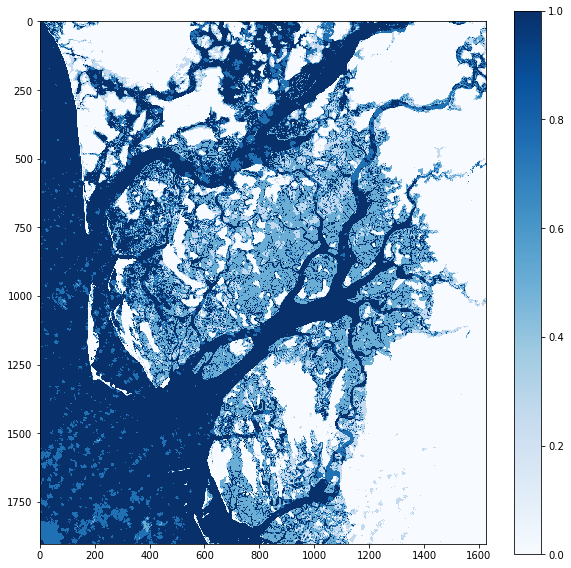

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(1,1,figsize=(10,10))
ploot = axes.imshow(water_frequency, cmap="Blues")
plt.colorbar(mappable=ploot)

We can still see some cloud artifacts over the ocean in the right lower corner. Lower the eo:cloudcov parameter to exclude clouded scenes. 

Check out the full tutorial on the [sat-search github repo](https://github.com/sat-utils/sat-search) to learn about the full functionalities.

## Congratulations! You've performed your (first) multi-temporal satellite image analysis!

## Exercise: Perform your own searches. 
Checkout the documentation of sat-search to get to know the query parameters. They have a good [jupyter notebook](https://github.com/sat-utils/sat-search/blob/master/tutorial-1.ipynb) to get started.

### Some Inspiration:
* extract the time series of one pixel and plot it as a pandas series.
* you could also do the imagery processing using googple earthin engine python bindings. 
* you could analyse the distribution of images.
* Use the tile splitter to do the processing in tiles
* save the images to file
* optimize your script to use efficient data types
* do the analyses for different seasons

## translate it to pyhton files